In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score

paper_style()

from helper_fn import *

sys.path.append("..")

# from modules.utils import paper_style

# loading GT stuff

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = False

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

crossing_points_gt, idx_gt = find_crossing_points(taus, gt_tracks)

track_lengths = [track.shape[0] for track in gt_tracks]

modalities = ["bf", "h2b"]
heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]

# df = pd.DataFrame(
#     columns=["head", "modality", "l1_error_green", "l1_error_red", "t_g", "t_r"]
# )


In [2]:
data = {}
for mod in modalities:
    data[mod] = {}
    for head in heads:
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

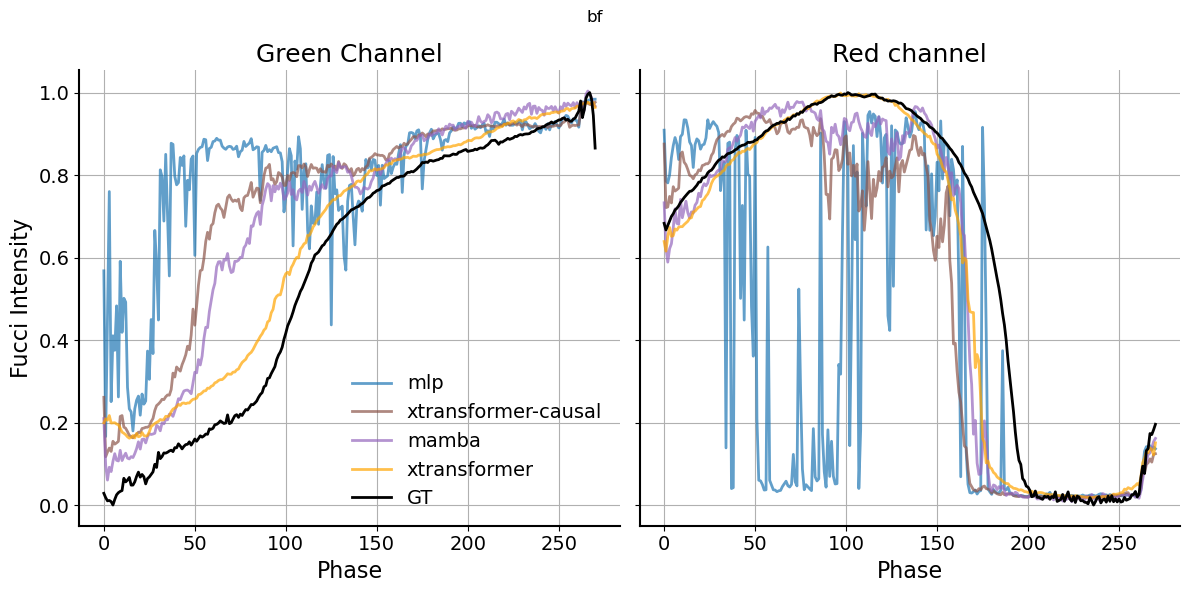

In [7]:
# Create the figure and subplots
mod = "bf"
idx = 119
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle(mod)

# Left subplot for errors_g_averaged
ax1.set_title("Green Channel")
ax1.set_xlabel("Phase")
ax1.set_ylabel("Fucci Intensity")


for head in good_heads:
    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color=head_colors[head], alpha=0.7)

ax1.plot(gt_tracks[idx][:, 0], label="GT", color="black")
ax1.legend()
ax1.grid()

# Right subplot for errors_r_averaged
ax2.set_title("Red channel")
ax2.set_xlabel("Phase")

for head in good_heads:
    ax2.plot(data[mod][head][idx][:, 1], label=f"{head}", color=head_colors[head], alpha=0.7)

ax2.plot(gt_tracks[idx][:, 1], label="GT", color="black")

# ax2.legend()
ax2.grid()

# Ensure tight layout and consistent y-axis scaling
plt.tight_layout()

# save the figure
plt.savefig(f"../plots/av_error/profile_{mod}.pdf")
plt.show()

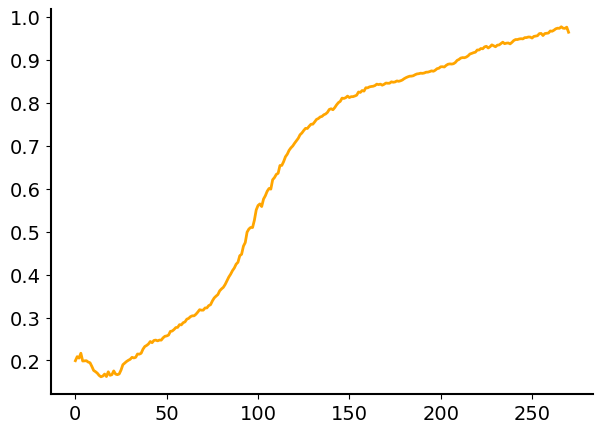

In [4]:
plt.plot(data[mod]["xtransformer"][idx][:, 0], label=f"{head}", color=head_colors["xtransformer"])

In [5]:
plot(data[mod][head][idx][:, 0], label=f"{head}", color=head_colors[head])

NameError: name 'plot' is not defined

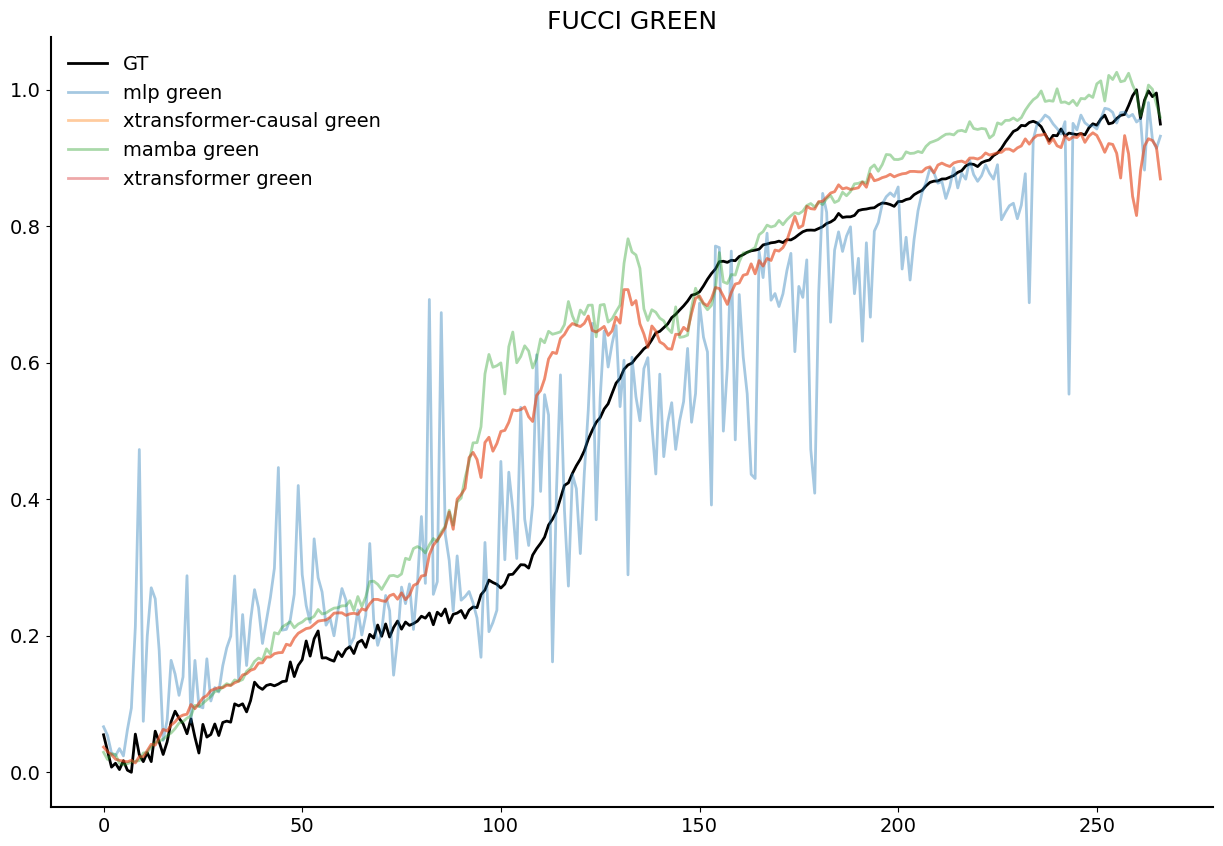

In [ ]:


plt.figure(figsize=(15, 10))
plt.title(f"FUCCI GREEN")
plt.plot(gt_tracks[idx][:, 0], label="GT", color="black")

# put colors in a list

mod = "bf"
for head in good_heads:
    plt.plot(data[mod][head][idx][:, 0], label=f"{head} green", alpha=0.4)

plt.legend()
# plt.plot(gt_tracks[idx][:, 1], label="gt red", color="r")

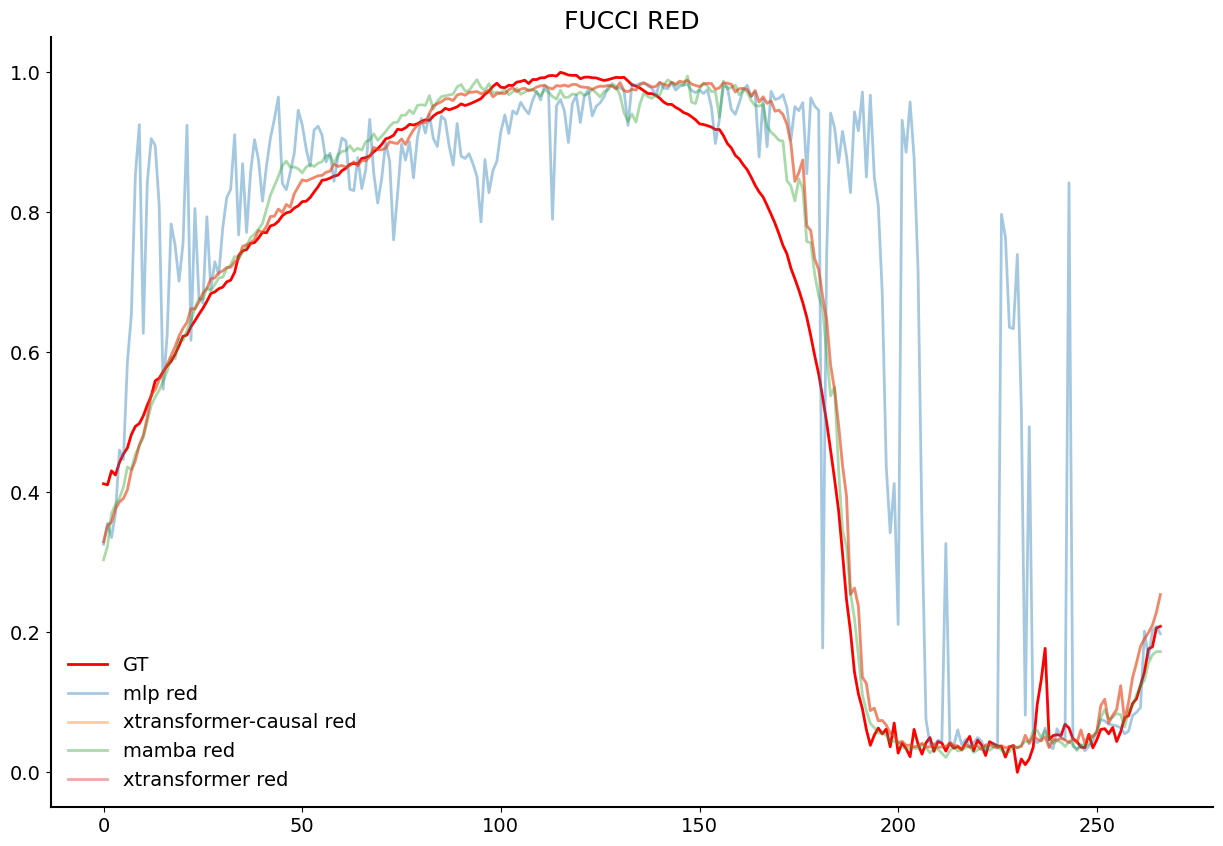

In [5]:
# same for red
plt.figure(figsize=(15, 10))
plt.title(f"FUCCI RED")
plt.plot(gt_tracks[idx][:, 1], label="GT", color="r")

mod = "bf"
for head in good_heads:
    plt.plot(data[mod][head][idx][:, 1], label=f"{head} red", alpha=0.4)

plt.legend()


# drugs

In [39]:
drug = True

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

data_d = {}
for mod in modalities:
    data_d[mod] = {}
    for head in heads:
        tracks = get_data(data_path_, mod, head)
        data_d[mod][head] = tracks

gt_tracks_d = []
taus_d = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks_d.append(track)
    taus_d.append(tau)

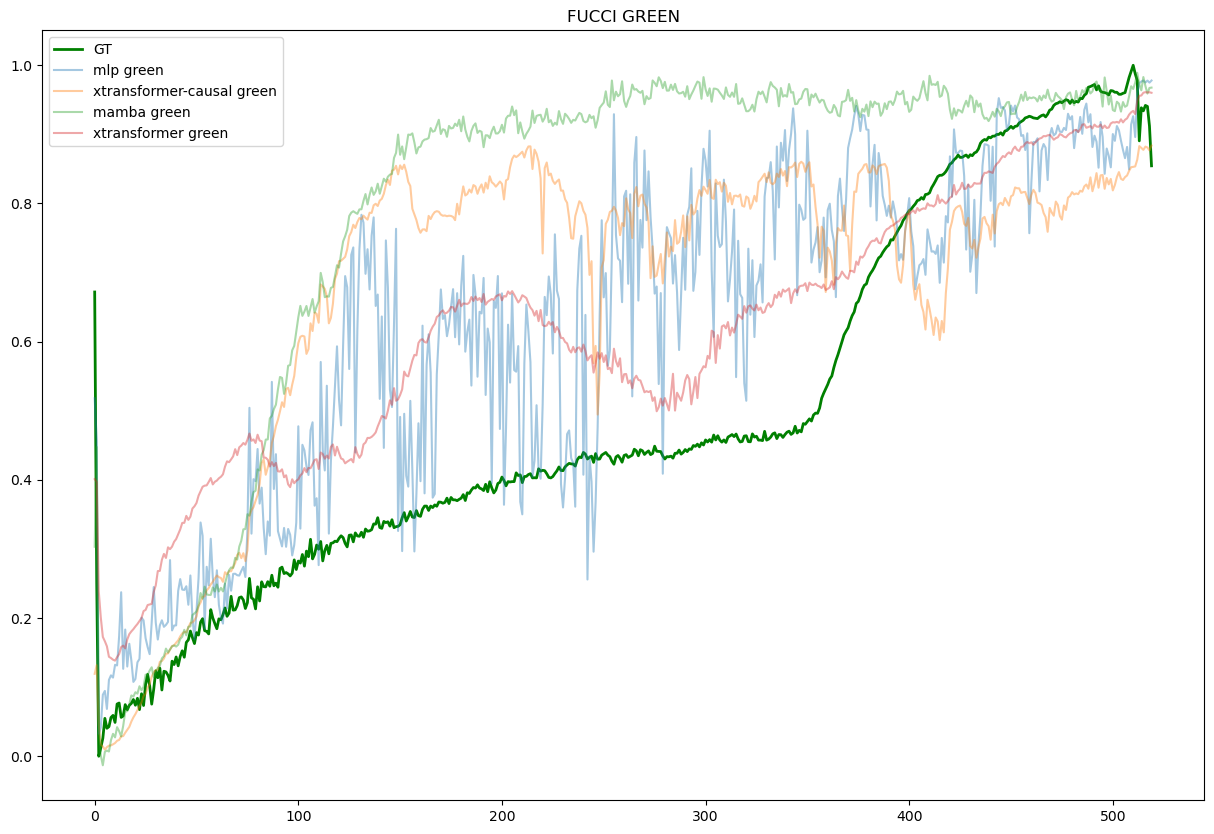

In [41]:
idx = 10

plt.figure(figsize=(15, 10))
plt.title(f"FUCCI GREEN")
# thick line
plt.plot(gt_tracks_d[idx][:, 0], label="GT", color="g", linewidth=2)

mod = "bf"
for head in good_heads:
    plt.plot(data_d[mod][head][idx][:, 0], label=f"{head} green", alpha=0.4)

plt.legend()

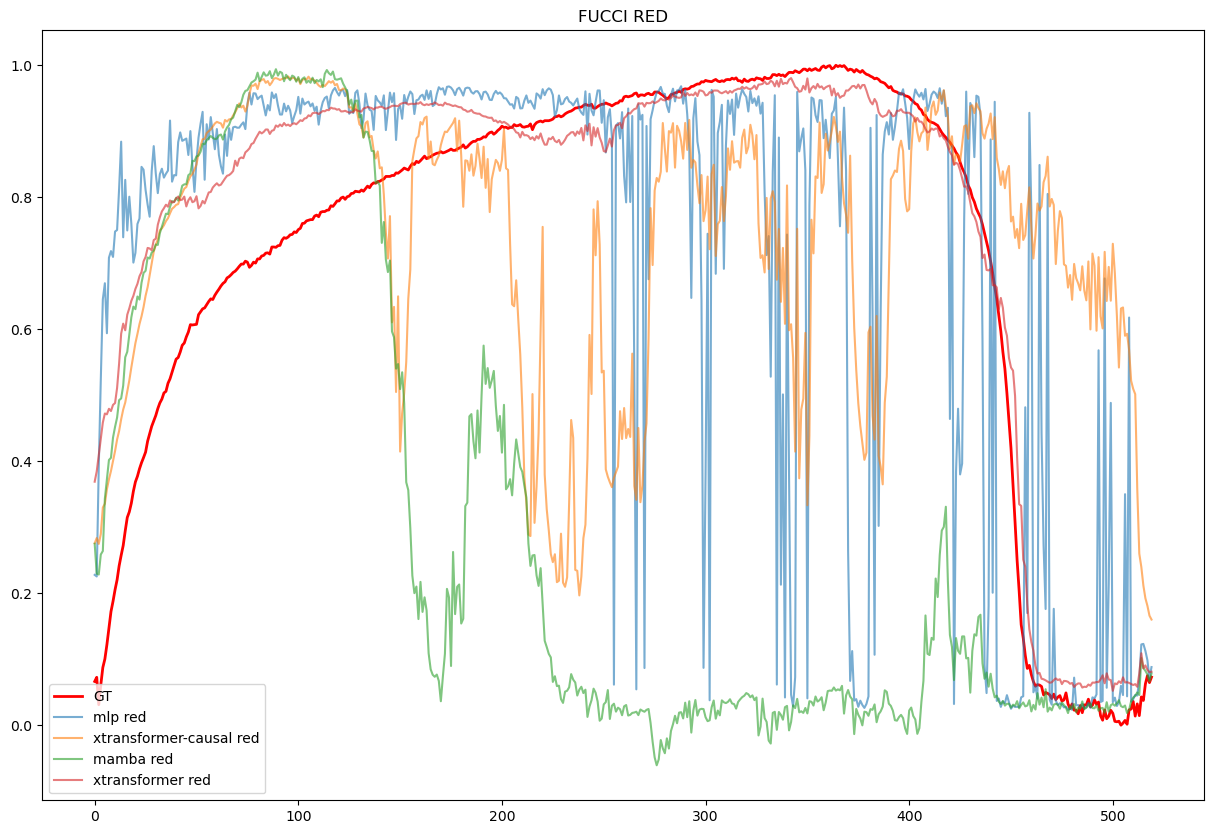

In [43]:
# fucci red
plt.figure(figsize=(15, 10))
plt.title(f"FUCCI RED")

plt.plot(gt_tracks_d[idx][:, 1], label="GT", color="r", linewidth=2)

mod = "bf"
for head in good_heads:
    plt.plot(data_d[mod][head][idx][:, 1], label=f"{head} red", alpha=0.6)

plt.legend()